In [1]:
!pip install pyGPGO

In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
### Data inputs:
n_test = 100
set_seed = 888 #initialise pseudo-random number generator, same start-point each time.

### Acquisition / Utility function - MLE/Type II:
d_util = 'dEI_GP'

n_init = 3  # Number of iterations used to initialise Bayesian optimisation; minimum 2
n_start_AcqFunc = 500 #multi-start iterations to avoid local optima in AcqFunc optimization

opt=False

In [4]:
### Objective Function - Sin(x) 1-D:

eps = 1e-8

def f_sine(x1_training):
    return operator * np.sin(x1_training)
        
def f_sine_eps(x1_training):
    return operator * np.sin(x1_training + eps)

# Constraints:
lb = 0
ub = 2 * np.pi
    
# Input array dimension(s):
dim = 1

# 1-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub])}
    
# True y bounds:
y_lb = 1 # targets global maximum 
operator = 1 # targets global maximum 
y_global_orig = y_lb * operator # targets global maximum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)

In [5]:
### Derivatives - Squared-exponential covariance function:

def l2norm_(X, Xstar):
    
    return cdist(X, Xstar)

def kronDelta(X, Xstar):

    return cdist(X, Xstar) < np.finfo(np.float32).eps

class squaredExponentialDeriv(squaredExponential):
    
    def K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        K = self.sigmaf * np.exp(-1/2*r **2) + self.sigman * kronDelta(X, Xstar)
        return K
    
    def dK(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        dK = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * l2norm_(X, Xstar)
        return dK
    
    def d2K(self, X, Xstar):
        
        r = (l2norm_(X, Xstar)/self.l)
        d2K = self.sigmaf/self.l**2 * np.exp(-1/2 * r **2) * (r **2 - 1)
        return d2K
    
cov_func = squaredExponential()
cov_func_hess = squaredExponentialDeriv()

In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list

In [7]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm, dvdv, d2s, d2m):
    
        z = (mean - tau - self.eps) / (std + self.eps)
        
        dsdx = ds / (std + self.eps)
        d2sdx = -dsdx**2 / ((std + self.eps)) - (dvdv + d2s) / (std + self.eps)
        dmdx = (dm - z * dsdx) / (std + self.eps)
        d2mdx = (d2m -(z * d2sdx + 2 * dmdx * dsdx)) / (std + self.eps)
        
        f = (std + self.eps) * (z * norm.cdf(z) + norm.pdf(z)[0])
        df = (z * norm.cdf(z) + norm.pdf(z)[0]) * dsdx + (std + self.eps) * norm.cdf(z) * dmdx
        d2f = (z * norm.cdf(z) + norm.pdf(z)[0]) * d2sdx + dsdx * dmdx * norm.cdf(z) \
            + d2mdx * (std + self.eps) * norm.cdf(z) + dsdx * norm.cdf(z) * dmdx \
            + norm.pdf(z)[0] * (std + self.eps) * dmdx
            
        return f, df, d2f
    
    def _eval(self, tau, mean, std):
    
        return self.f(tau, mean, std, **self.params)
    
    def d_eval(self, tau, mean, std, ds, dm, dvdv, d2s, d2m):
    
        return self.f(tau, mean, std, ds, dm, dvdv, d2s, d2m, **self.params)

In [8]:
### Surrogate derivatives: 

class dGaussianProcess(GaussianProcess):
    l = 1
    sigmaf = 1e-4
    sigman = 1e-6

    def AcqGrad(self, Xstar, return_std=False):
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponentialDeriv.K(self, self.X, Xstar).T
        dKstar = squaredExponentialDeriv.dK(self, self.X, Xstar).T
        d2Kstar = squaredExponentialDeriv.d2K(self, self.X, Xstar).T
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        d2v = solve(self.L, d2Kstar.T)
        
        ds = -np.dot(dv.T, v)
        d2s = np.dot(d2v.T, v)
        dvdv = np.dot(dv.T, dv)
        
        dm = np.dot(dKstar, self.alpha)
        d2m = np.dot(d2Kstar, self.alpha)
        return ds, dm, dvdv, d2s, d2m

In [9]:
### dGPGO - BayesOpt class:

class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
        
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2s, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
        
    def d_optimizeAcq(self, method='Newton-CG', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [10]:
### d2GPGO - BayesOpt class: Exact Hessian

class d2GPGO(GPGO):  
    n_start = n_start_AcqFunc
    p = np.full((n_start,1),1)
    
    def func(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2s, d2m = self.GP.AcqGrad(xnew, return_std=True)
        f  = np.empty((self.n_start,))
        df = np.empty((self.n_start,))
        f  = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[0]
        df = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[1]
        df_array = np.full((len(xnew),),df)
        return f, df_array
    
    def hessp_nonzero(self, xnew, p):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + 1e-6)
        ds, dm, dvdv, d2s, d2m = self.GP.AcqGrad(xnew, return_std=True)
        df2 = np.empty((self.n_start,))
        df2 = -self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm, dvdv=dvdv, d2s=d2s, d2m=d2m)[2]
        H2 = np.empty((self.n_start,))
        df2 = np.asarray(df2)
        p = np.asarray(p)
        H2 = np.multiply(df2,p)
        return H2
    
    def d_optimizeAcq(self, method='Newton-CG', n_start=n_start):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.func,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 hessp = self.hessp_nonzero,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

    def run(self, max_iter=10, init_evals=3, resume=False):    
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

In [11]:
### Set iterations:

max_iter = 0

In [12]:
acq_1 = Acquisition_new(d_util)
d_acq_list1 = [acq_1]
param = {'x1_training': ('cont', [0, 2 * np.pi])}

new = True
color = ['red']
acq_title = ['GP EI$(\mathbf{x})$: Newton-CG with GP d$^{2}$EI']

for index, d_acq in enumerate(d_acq_list1):
    np.random.seed(set_seed)
    dgp = dGaussianProcess(cov_func_hess, optimize=opt)
    d2gpgo = d2GPGO(dgp, d_acq, f_sine, param)
    d2gpgo.run(init_evals=n_init, max_iter=max_iter)
    new = False

d2gpgo.d_optimizeAcq(method='Newton-CG')

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911


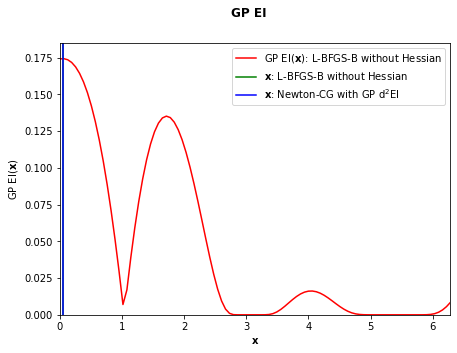

In [13]:
### Acquisition plots: L-BFGS-B without Hessian

def plot_dGPGO(dgpgo, param, index, new):
    plt.figure(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = np.array([-dgpgo.func(np.atleast_1d(x))[0] for x in x_test]).flatten()
    plt.plot(x_test, a, color=color[index - 2], label=acq_title[index - 2])
    plt.ylim(0,.185)
    plt.xlim(0, 2 * np.pi)
    dgpgo.d_optimizeAcq(method='L-BFGS-B')
    plt.axvline(dgpgo.best, color='g', label='$\mathbf{x}$: L-BFGS-B without Hessian')
    plt.axvline(d2gpgo.best, color='b', label='$\mathbf{x}$: Newton-CG with GP d$^{2}$EI')
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP EI$(\mathbf{x})$")

acq_1 = Acquisition_new(d_util)
d_acq_list1 = [acq_1]
param = {'x1_training': ('cont', [0, 2 * np.pi])}

new = True
color = ['red']
acq_title = ['GP EI$(\mathbf{x})$: L-BFGS-B without Hessian']

for index, d_acq in enumerate(d_acq_list1):
    np.random.seed(set_seed)
    dgp = dGaussianProcess(cov_func, optimize=opt)
    dgpgo = dGPGO(dgp, d_acq, f_sine, param)
    dgpgo.run(init_evals=n_init, max_iter=max_iter)
    plot_dGPGO(dgpgo, param, index=index+2, new=new)
    new = False
    
title = 'GP EI'
plt.suptitle(title, weight = 'bold')    
plt.show()

In [14]:
x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))

In [15]:
dgpgo.best[0], f_sine(dgpgo.best)[0]

(0.050451050423865655, 0.050429650899647356)

In [16]:
d2gpgo.best[0], f_sine(d2gpgo.best)[0]

(0.054250260951917886, 0.05422365429340539)

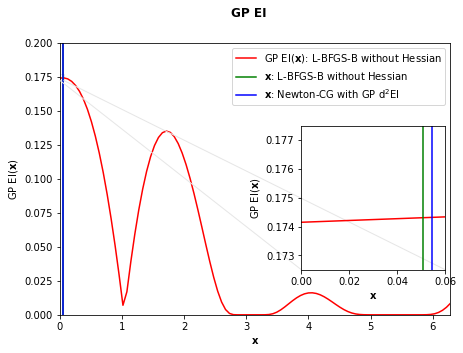

In [17]:
### Acquisition plots: L-BFGS-B without Hessian
## Zoom-in on maximized acquisition function region:

fig, ax = plt.subplots(figsize=[7,5])
x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
a = np.array([-dgpgo.func(np.atleast_1d(x))[0] for x in x_test]).flatten()
plt.plot(x_test[0:], a[0:], color='r', label='GP EI$(\mathbf{x})$: L-BFGS-B without Hessian')
plt.axvline(dgpgo.best, color='g', label='$\mathbf{x}$: L-BFGS-B without Hessian')
plt.axvline(d2gpgo.best, color='b', label='$\mathbf{x}$: Newton-CG with GP d$^{2}$EI')
plt.ylim(0,.2)
plt.xlim(0,2 * np.pi)
plt.legend(loc=1)
plt.xlabel("$\mathbf{x}$")
plt.ylabel("GP EI$(\mathbf{x})$")
title = 'GP EI'
plt.suptitle(title, weight = 'bold')

axins = inset_axes(ax, 2, 2, loc=7, bbox_to_anchor=(0.9, 0.45),bbox_transform=ax.figure.transFigure) # no zoom
axins.plot(x_test[0:], a[0:], color='r', label='GP EI$(\mathbf{x})$: excl. Hessian')
axins.set_xlim(0, 0.06) # Limit the region for zoom
axins.set_ylim(0.1725, 0.1775)
plt.xlabel("$\mathbf{x}$")
plt.ylabel("GP EI$(\mathbf{x})$")
axins.set_autoscaley_on(True)
plt.axvline(dgpgo.best, color='g', label='$\mathbf{x}$: excl. Hessian')
plt.axvline(d2gpgo.best, color='b', label='$\mathbf{x}$: with GP d$^{2}$EI')
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.9")
plt.draw()
plt.show()

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911


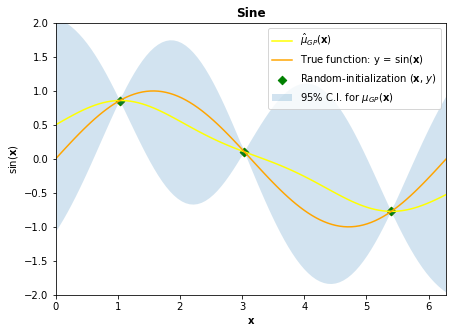

In [18]:
def plot_sine(d2gpgo, param, index, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = d2gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std # z-score, 95% confidence (two-tail)
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(d2gpgo.GP.X, d2gpgo.GP.y, marker ='D', color = 'Orange')
        plt.scatter(d2gpgo.X, d2gpgo.y, marker ='D', color = 'Green', label='Random-initialization ($\mathbf{x}$, $y$)')
        plt.ylim(-2,2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), y_hat, color = 'Yellow', label='$\hat{\mu}_{GP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), np.sin(x_test.flatten()), color = 'Orange', label='True function: y = sin($\mathbf{x}$)')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% C.I. for $\mu_{GP}(\mathbf{x})$')
        title = 'Sine'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$)")
        plt.legend(loc=0)
        plt.show()

acq_1 = Acquisition_new(d_util)
d_acq_list1 = [acq_1]
param = {'x1_training': ('cont', [0, 2 * np.pi])}

new = True
color = ['blue']
acq_title = ['GP d$^{2}$EI: exact Hessian']

for index, d_acq in enumerate(d_acq_list1):
    np.random.seed(set_seed)
    dgp = dGaussianProcess(cov_func, optimize=opt)
    d3gpgo = d2GPGO(dgp, d_acq, f_sine, param)
    d3gpgo.run(init_evals=n_init, max_iter=max_iter)
    new = False

plot_sine(d3gpgo, param, index, new=True)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911


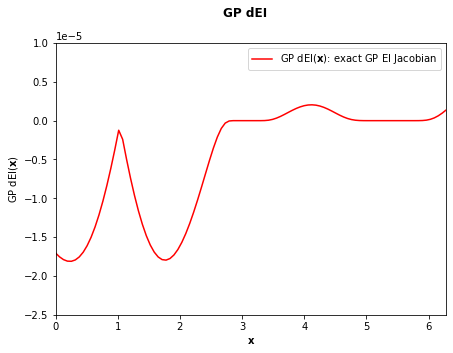

In [19]:
def plot_jacobian(d2gpgo, param, index, new):
    plt.figure(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    jac = np.array([d2gpgo.func(np.atleast_1d(x))[1] for x in x_test]).flatten()
    plt.plot(x_test, jac, color='r', label='GP dEI$(\mathbf{x})$: exact GP EI Jacobian')
    plt.ylim(-.000025,0.00001)
    plt.xlim(0,2 * np.pi)
    d2gpgo.d_optimizeAcq(method='Newton-CG', n_start=100)
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP dEI$(\mathbf{x})$")
    
acq_1 = Acquisition_new(d_util)
d_acq_list1 = [acq_1]
param = {'x1_training': ('cont', [0, 2 * np.pi])}

new = True
color = ['red']
acq_title = ['GP dEI$(\mathbf{x})$: exact GP EI Jacobian']

for index, d_acq in enumerate(d_acq_list1):
    np.random.seed(set_seed)
    dgp = dGaussianProcess(cov_func, optimize=opt)
    d2gpgo = d2GPGO(dgp, d_acq, f_sine, param)
    d2gpgo.run(init_evals=n_init, max_iter=max_iter)
    plot_jacobian(d2gpgo, param, index=index+2, new=new)
    new = False

title = 'GP dEI'
plt.suptitle(title, weight = 'bold')    
plt.show()

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [5.40077857]. 	  -0.7722701001578773 	 0.8593619530727911
init   	 [1.03402064]. 	  0.8593619530727911 	 0.8593619530727911
init   	 [3.03776904]. 	  0.103637186120003 	 0.8593619530727911


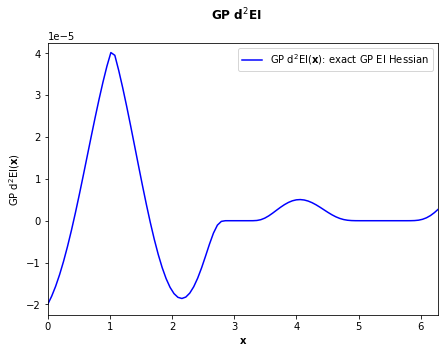

In [20]:
def plot_hess(d2gpgo, param, index, new):
    plt.figure(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    h = np.array([d2gpgo.hessp_nonzero(np.atleast_1d(x),p=1)[0] for x in x_test]).flatten()
    plt.plot(x_test, h, color=color[index - 2], label=acq_title[index - 2])
    plt.ylim(-.0000225,.0000425)
    plt.xlim(0,2 * np.pi)
    d2gpgo.d_optimizeAcq(method='Newton-CG', n_start=100)
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP d$^{2}$EI$(\mathbf{x})$")
    
acq_1 = Acquisition_new(d_util)
d_acq_list1 = [acq_1]
param = {'x1_training': ('cont', [0, 2 * np.pi])}

new = True
color = ['blue']
acq_title = ['GP d$^{2}$EI$(\mathbf{x})$: exact GP EI Hessian']

for index, d_acq in enumerate(d_acq_list1):
    np.random.seed(set_seed)
    dgp = dGaussianProcess(cov_func, optimize=opt)
    d2gpgo = d2GPGO(dgp, d_acq, f_sine, param)
    d2gpgo.run(init_evals=n_init, max_iter=max_iter)
    plot_hess(d2gpgo, param, index=index+2, new=new)
    new = False

title = 'GP d$^{2}$EI'
plt.suptitle(title, weight = 'bold')    
plt.show()

In [21]:
hess = np.array([d2gpgo.hessp_nonzero(np.atleast_1d(x),p=1)[0] for x in x_test]).flatten()
hess.min(), hess.max()

(-1.9989076081066853e-05, 4.021367990894519e-05)